# import library

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import datetime
from tqdm import tqdm
%matplotlib inline

# api key registeration

In [4]:
apikey = 'yourkey'
api = f'https://min-api.cryptocompare.com/data/v2/histominute?fsym=BTC&tsym=GBP&limit=2000&api_key={apikey}'

In [5]:
data = requests.get(api)
data_ = data.json()['Data']['Data']
df = pd.json_normalize(data_)

[source](https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html)

# compare current close value

In [6]:
df['high'] - df['low']

0       16.34
1       28.48
2       23.99
3       26.28
4       22.18
        ...  
1996    54.51
1997    26.21
1998    21.11
1999    16.92
2000     3.24
Length: 2001, dtype: float64

# compare previous close value

In [7]:
difference_one = []
for i in range(len(df)-1):
    difference_one.append(df['close'][i] - df['close'][i+1])

In [8]:
diff = pd.DataFrame(difference_one)

In [9]:
time = pd.DataFrame(df['time'])

In [10]:
diffbox = pd.concat([diff, time],axis=1).rename(columns={0:'diff'})

In [11]:
diffbox

diff        time
0    -18.69  1645575240
1    -23.58  1645575300
2      5.28  1645575360
3     15.64  1645575420
4     13.31  1645575480
...     ...         ...
1996   4.87  1645695000
1997   7.91  1645695060
1998   9.78  1645695120
1999  -3.24  1645695180
2000    NaN  1645695240

[2001 rows x 2 columns]

In [14]:
plt.figure(figsize=(15,8))
plt.title("Histogram of diff", fontsize=15)
frq, bins, fig = plt.hist(diffbox["diff"], bins=50, alpha=.8, color='blue')
plt.grid()
plt.show()
print("*빈도 array :", frq)
print("*구간 array :", bins)

*빈도 array : [  2.   1.   0.   1.   1.   0.   1.   1.   1.   2.   6.   6.  11.  18.
  22.  35.  69. 133. 247. 397. 406. 289. 132.  79.  44.  40.  22.   8.
  10.   1.   3.   2.   2.   1.   3.   1.   0.   1.   0.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   1.]
*구간 array : [-195.38   -185.6476 -175.9152 -166.1828 -156.4504 -146.718  -136.9856
 -127.2532 -117.5208 -107.7884  -98.056   -88.3236  -78.5912  -68.8588
  -59.1264  -49.394   -39.6616  -29.9292  -20.1968  -10.4644   -0.732
    9.0004   18.7328   28.4652   38.1976   47.93     57.6624   67.3948
   77.1272   86.8596   96.592   106.3244  116.0568  125.7892  135.5216
  145.254   154.9864  164.7188  174.4512  184.1836  193.916   203.6484
  213.3808  223.1132  232.8456  242.578   252.3104  262.0428  271.7752
  281.5076  291.24  ]


In [190]:
display(diffbox[diffbox['diff'] == diffbox['diff'].min()])
display(diffbox[diffbox['diff'] == diffbox['diff'].max()])
mints = diffbox[diffbox['diff'] == diffbox['diff'].min()].time
maxts = diffbox[diffbox['diff'] == diffbox['diff'].max()].time
display(datetime.datetime.utcfromtimestamp(mints).strftime('%Y-%m-%d %H:%M'))
display(datetime.datetime.utcfromtimestamp(maxts).strftime('%Y-%m-%d %H:%M'))

diff        time
1669 -195.38  1645675380

diff        time
1601  291.24  1645671300

/tmp/ipykernel_117919/197831587.py:5: DeprecationWarning: an integer is required (got type Series).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  display(datetime.datetime.utcfromtimestamp(mints).strftime('%Y-%m-%d %H:%M'))


'2022-02-24 04:03'

/tmp/ipykernel_117919/197831587.py:6: DeprecationWarning: an integer is required (got type Series).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  display(datetime.datetime.utcfromtimestamp(maxts).strftime('%Y-%m-%d %H:%M'))


'2022-02-24 02:55'

# automating 

In [325]:
# you assign the pagecounts at 'pagerange'
timelist = []
blocklist = []
onepageselector = 52
pagerange=10

for page in tqdm(range(pagerange)):
    page = requests.get(f'https://www.blockchain.com/btc/blocks?page={i}')
    soup = BeautifulSoup(page.text, 'html.parser')
    for i in range(2,onepageselector):
        blockselector = f'#__next > div.sc-1udt3q6-0.irpFhx > div.sc-1udt3q6-1.ijayGs > div > div > div:nth-child(2) > div > div:nth-child({i}) > div.sc-1au2w4e-0.kLjLbm > div.sc-6nt7oh-0.PtIAf > a' 
        timeselector = f'#__next > div.sc-1udt3q6-0.irpFhx > div.sc-1udt3q6-1.ijayGs > div > div > div:nth-child(2) > div > div:nth-child({i}) > div:nth-child(3) > div.sc-6nt7oh-0.PtIAf > span'
        timelist.append(soup.select_one(timeselector).text)
        for k in range(10):
            blocklist.append(soup.find_all('div', class_='sc-6nt7oh-0 PtIAf')[0 + 5 * k].text)
        

autodf = pd.DataFrame(list(zip(blocklist, timelist)), columns=['block','time'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.22s/it]


# each min,max block extraction

In [341]:
minblockname = '000000000000000000035563c486c5a6a4fcc1ba436310268bfdfec280ce6f58'
maxblockname = '00000000000000000002fd54794658988631588d871cd8abcea8c009b3b15d1e'

In [342]:
minblock = requests.get(f'https://blockchain.info/rawblock/{minblockname}').json()
maxblock = requests.get(f'https://blockchain.info/rawblock/{maxblockname}').json()

# minblock insight

In [343]:
minblocktx = pd.json_normalize(minblock['tx'])

## inaddr extraction

In [347]:
minblocktx['addrin'] = ''
for i in range(len(minblocktx)):
    # vin sz 가 1 인 경우
    if minblocktx['vin_sz'][i] == 1:
        minblocktx['addrin'][i] = minblocktx['inputs'][i][0]['prev_out']
    # vin sz 가 1 이상인 경우
    if minblocktx['vin_sz'][i] >= 1:
        assert minblocktx['vin_sz'][i] == len(minblocktx['inputs'][i])
        counts = minblocktx['vin_sz'][i]
        for count in range(counts):
            try:
                minblocktx['addrin'][i] = minblocktx['inputs'][i][count]['prev_out']['addr']
            except:
                print(i, count)            

/tmp/ipykernel_117919/2329222414.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minblocktx['addrin'][i] = minblocktx['inputs'][i][0]['prev_out']
/tmp/ipykernel_117919/2329222414.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minblocktx['addrin'][i] = minblocktx['inputs'][i][count]['prev_out']['addr']


0 0


## outaddr extraction

In [346]:
minblocktx['addrout'] = ''
minblocktx['value'] = ''
for i in range(len(minblocktx)):
    temp1 = []
    temp2 = []
    try:
        for count in range(len(minblocktx['out'][i])):
            temp1.append(minblocktx['out'][i][count]['addr'])
            temp2.append(minblocktx['out'][i][count]['value'])
            minblocktx['addrout'][i] = temp1
            minblocktx['value'][i] = temp2
    except:
        print(i, count)

/tmp/ipykernel_117919/606658161.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minblocktx['addrout'][i] = temp1
/tmp/ipykernel_117919/606658161.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minblocktx['value'][i] = temp2


0 1
165 0
166 0
178 1
301 0
304 0
305 0
321 0
1217 0
1301 0
1302 0
1304 0
1667 0
1668 0
1850 0
1851 0
1969 0
2572 2
2752 0
2753 0
2917 0
2937 2
2991 0
2992 0
2993 0
3068 1


# unwind the feature value , addrout 

In [349]:
minblocktx_1 = minblocktx.explode('addrout')
valueexplode = minblocktx.explode('value')['value']
minblocktx_1['value2'] = valueexplode
minblocktx_2 = minblocktx_1[['time','addrin','addrout','value2']]
minblocktx_3 = minblocktx_2[1:]

# convert to networkx format

### digraph

In [352]:
G = nx.from_pandas_edgelist(minblocktx_3, \
                            source='addrin', \
                            target='addrout', \
                            edge_attr='value2', \
                           create_using=nx.DiGraph())

### graph

In [375]:
G = nx.from_pandas_edgelist(minblocktx_3, \
                            source='addrin', \
                            target='addrout', \
                            edge_attr='value2')

# EDA 

## Basic topological attributes

In [353]:
G.number_of_nodes()

11129

In [354]:
G.number_of_edges()

9643

In [355]:
np.mean([d for _, d in G.degree()])

1.732949950579567

## shortestpath -> diameter

In [357]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [ ]:
# if you want to check the shortestpath at the network reversed then typing this line
# (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

In [141]:
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())

NetworkXError: Found infinite path length because the graph is not connected

### density

In [358]:
nx.density(G)

7.786439389735653e-05

## centrality measures

### degree centrality

In [360]:
degree_centrality = nx.centrality.degree_centrality(G)

In [361]:
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[('bc1qm34lsc65zpw79lxes69zkqmk6ee3ewf0j77s3h', 0.025071890726096335),
 ('3DKVVUJVuz45vZsHnrBPA4hkaiziNUPJBN', 0.017972681524083396),
 ('bc1qlzgeuazzr6pjj93rl7xfjrmuwp6976gzrq6v78lqzx0dqlaszq3s5u0eha',
  0.017343637670740476),
 ('bc1qf8fhznt8lnnrc24zjskxrghvvfngjpgfe8ssp5t9ppfmzm0a7yzqelly03',
  0.010424155283968369),
 ('bc1q90xj8ck5l6930tmvl8gu086tpl83ptaj5f4kwc', 0.009615384615384616),
 ('bc1qwfgdjyy95aay2686fn74h6a4nu9eev6np7q4fn204dkj3274frlqrskvx0',
  0.008716750539180446),
 ('bc1qcs4zytux6f7xqg3zvayfkpz6r4wqs3eteyphlw', 0.007189072609633357),
 ('bc1qtqlfwrqpj0z9m56tntf2yxmdvw4lyn60mck796', 0.0066498921639108555),
 ('bc1q7mxj0rhveraa6pkz0r4pvdwzqhfkadp2nr9p2w', 0.006470165348670022),
 ('bc1qlh6v3gkuu5nz4t6w4pqd09flc8uqnxsm5jcyhr', 0.006470165348670022)]

In [187]:
print(np.mean(list(degree_centrality.values())))
print(np.min(list(degree_centrality.values())))
print(format(np.min(list(degree_centrality.values())), '.18f'))
print(np.max(list(degree_centrality.values())))

0.00015568033955626196
8.986340762041697e-05
0.000089863407620417
0.025071890726096335
0.000089863407620417


(-1.206013304591179, 1.2096211737394333, -1.206522186100483, 1.24507503658533)

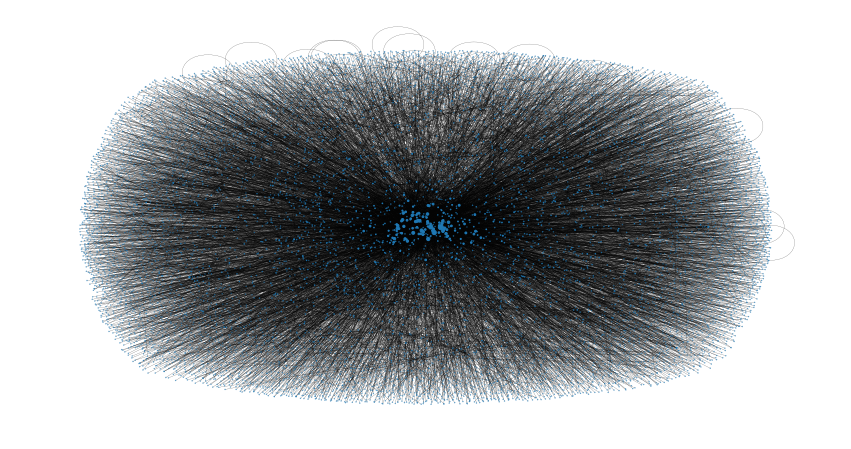

In [193]:
node_size =  [v * 1000 for v in degree_centrality.values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis('off')

## betweenness centrality

In [362]:
betweenness_centrality = nx.centrality.betweenness_centrality(G)

## closeness centrality

In [364]:
closeness_centrality = nx.centrality.closeness_centrality(G)  # save results in a variable to use again 

## eigenvector centrality

In [367]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(G)  # save results in a variable to use again 

In [368]:
high_eigenvector_centralities = ((sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[1:10])

In [369]:
high_eigenvector_nodes = [tuple[0] for tuple in high_eigenvector_centralities]  # set list as [2266, 2206, 2233, 2464, 2142, 2218, 2078, 2123, 1993]

## clustering effects

In [371]:
nx.average_clustering(G)


0.0015264199477136192

## Assortativity

In [373]:
nx.degree_assortativity_coefficient(G)

-0.056999507039380164

In fact, the assortativity coefficient is the Pearson correlation coefficient of degree between pairs of linked nodes. That means that it takes values from  to . In detail, a positive assortativity coefficient indicates a correlation between nodes of similar degree, while a negative indicates correlation between nodes of different degrees.



# community

In [389]:
for com in nx.community.label_propagation_communities(G):
    print(len(com))

2
5
4
3
3
3
3
3
7
2
5
2
29
2
2
2
3
66
3
3
2
2
3
2
38
2
3
8
2
2
2
3
2
2
2
3
2
4
2
3
3
3
4
3
3
5
3
3
4
4
5
15
5
7
3
2
3
4
11
2
6
3
3
3
3
2
2
7
267
8
2
2
2
2
3
3
6
3
8
3
2
3
3
22
3
3
3
2
3
5
5
4
8
18
2
5
3
3
3
2
2
2
4
2
16
3
2
4
13
2
3
12
2
3
3
2
2
2
2
3
2
3
11
2
2
2
2
3
1
2
2
2
2
3
3
2
2
3
2
2
3
2
2
2
2
3
3
2
2
3
2
2
3
2
3
2
3
3
3
2
2
2
2
2
2
2
2
2
2
2
3
2
3
2
3
3
2
3
2
3
3
2
4
2
3
3
3
3
3
3
3
3
3
2
3
10
3
4
3
3
3
4
3
2
2
2
3
3
2
1
3
3
2
2
3
2
3
3
3
2
2
2
2
2
58
3
5
2
2
3
2
2
2
3
2
1
3
6
2
3
5
13
2
3
2
3
3
3
3
3
3
3
3
3
5
2
2
2
2
2
3
2
2
2
2
3
2
2
3
2
3
2
2
2
3
4
2
2
3
3
3
3
4
2
5
4
2
2
3
2
3
3
2
2
3
2
2
3
2
34
3
4
14
2
2
3
3
3
13
12
3
3
3
6
2
3
3
1
2
3
2
4
4
2
3
3
2
2
2
4
2
2
2
2
2
3
4
3
3
2
3
2
2
2
4
3
3
2
1
2
3
2
2
2
2
2
3
190
2
2
2
2
24
2
2
2
3
2
2
3
2
2
3
3
2
4
3
2
2
3
2
4
3
2
3
2
63
2
2
2
72
2
69
2
3
2
3
2
1
2
2
3
2
2
2
2
3
2
2
2
1
3
2
2
2
3
3
3
2
2
2
3
2
3
2
2
3
2
3
2
3
2
2
2
2
1
2
2
4
2
2
2
4
2
3
3
2
3
2
3
3
3
3
2
2
2
3
6
4
3
3
4
2
2
2
3
1
3
2
4
3
52
10
5
5
3
2
1
2
2
2
2
3
3
3
2


In [400]:
colors = ['' for x in range (G.number_of_nodes())]  # initialize colors list
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = '#%06X' % np.random.randint(0, 0xFFFFFF)  # creates random RGB color
    counter += 1
    for node in list(com):  # fill colors list with the particular color for the community nodes
        for i in range(len(colors)):
            colors[i] = color

# maxblock insight

In [81]:
maxblock['tx']

[{'hash': '314d4f5d9aa2595cac98432e5bb71ac56b519c2ec141f33bd8a0af5eef161039',
  'ver': 1,
  'vin_sz': 1,
  'vout_sz': 5,
  'size': 405,
  'weight': 1512,
  'fee': 0,
  'relayed_by': '0.0.0.0',
  'lock_time': 1867359762,
  'tx_index': 2007720545474036,
  'double_spend': False,
  'time': 1645237885,
  'block_index': 723968,
  'block_height': 723968,
  'inputs': [{'sequence': 4294967295,
    'witness': '01200000000000000000000000000000000000000000000000000000000000000000',
    'script': '03000c0b047e5610622f706f6f6c696e2e636f6d2ffabe6d6d19a79b9c0371e51d1eb05747caf95f0691e6aa8bb082a7f67d043dc55812b26f010000000000000056cf7302767a2426abc26790c6d56ed11200a52a0a0000000000',
    'index': 0,
    'prev_out': {'spent': True,
     'script': '',
     'spending_outpoints': [{'tx_index': 2007720545474036, 'n': 0}],
     'tx_index': 0,
     'value': 0,
     'n': 4294967295,
     'type': 0}}],
  'out': [{'type': 0,
    'spent': False,
    'value': 628333646,
    'spending_outpoints': [],
    'n': 0,
   